In [3]:
using GLM, PyPlot, Printf, DataFrames, Dates, DelimitedFiles

In [4]:
include("decode.jl")
include("utils.jl")
include("updateRule.jl")
include("readData.jl");

In [5]:
function computeShannonSurprise(rule, x_t, col)
    theta = rule.computeTheta(col)
    theta = x_t == 1 ? theta : 1 - theta
    return -log(theta) / log(2.0)
end

function decodeShannonSurprise(seq, m, alpha_0, rule, ignoreFirstM = true)
    # define callback to compute Shannon surprises
    callback = Callback(computeShannonSurprise, Float64)

    # decode sequence
    surprises = decode(seq, m, alpha_0, rule;
                       callback = callback, ignoreFirstM = ignoreFirstM)
    
    if ignoreFirstM && m > 0
        surprises[1:m] .= -log(0.5) / log(2.0)
    end
    
    return surprises
end;

In [7]:
function regression(subject, sensor, time, rule, m, alpha_0)
    
    surprises = decodeShannonSurprise.(subject.seq, m, Ref(alpha_0), Ref(rule))
    surprises = map((s,i) -> s[i], surprises, subject.seqIdx)
    
    megs = map(m -> m[:,sensor,time], subject.meg)
    
    # calc regression
    surprises1d = reduce(vcat, surprises)
    megs1d = reduce(vcat, megs)

    data = DataFrame(X=surprises1d, Y=megs1d)
    ols = lm(@formula(Y ~ 1 + X), data)
        
    return surprises, megs, ols
end;

In [76]:
function plotMEG(x, y, params)
    scatter(x, y, alpha=0.7, s=1, label=@sprintf("block = %i", params["block"]))
    
    title(@sprintf("%s using update rule %s, m = %i", params["title"], params["rule"], params["m"]))
    xlabel("Surprise (bits)")
    ylabel("MEG activity (pT)")
    
    grid(true)
    legend()
end;

In [69]:
# load subject data
sub13 = loadSubjectData(getFilename(13));
sub16 = loadSubjectData(getFilename(16));

In [70]:
map(findmax, sub13.meg)

4-element Array{Tuple{Float64,CartesianIndex{3}},1}:
 (108.5539210884446, CartesianIndex(20, 205, 253))  
 (71.74794207479695, CartesianIndex(128, 169, 209)) 
 (68.64706784014598, CartesianIndex(111, 118, 157)) 
 (110.97381138917638, CartesianIndex(119, 104, 317))

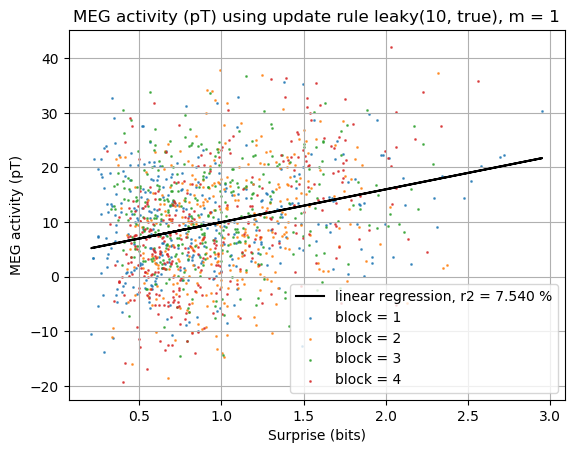

In [94]:
m = 1
rule = leaky(10, true)

# define initial params
alpha_0 = ones(2, 2^m)

# define which data we look at
subject = sub16
sensor = 211 # in range [1, 306] 37
time = 127 # in range [1, 321] 120

surprises, megs, ols = regression(subject, sensor, time, rule, m, alpha_0)

@inbounds for i in eachindex(surprises)    
    # plot surprises
    infos = Dict(
        "title"   => "MEG activity (pT)", 
        "m"       => m,
        "sensor"  => sensor,
        "rule"    => rule.str,
        "block"   => i
    )
    
    plotMEG(surprises[i], megs[i], infos)
end

r2val = @sprintf("%.3f %%", 100 * r2(ols))
plot(reduce(vcat, surprises), predict(ols), "k", label="linear regression, r2 = $r2val")
legend()
;

In [90]:
sub.megData

Dict{String,Any} with 7 entries:
  "label"     => Any["MEG0111"; "MEG0121"; … ; "MEG2632"; "MEG2643"]
  "trial"     => [6.43514e-14 1.26816e-13 … -5.87346e-13 -1.15599e-12; 1.75136e…
  "dimord"    => "rpt_chan_time"
  "time"      => [-0.25 -0.246094 … 0.996094 1.0]
  "trialinfo" => [1293.0 3.0 4.0 1.0; 1294.0 4.0 4.0 2.0; … ; 410.0 410.0 1.0 2…
  "cfg"       => Dict{String,Any}("bpfiltwintype"=>"hamming","resample"=>"","de…
  "version"   => Dict{String,Any}("bpfiltwintype"=>"hamming","resample"=>"","de…

In [91]:
sub.megData["label"]

306×1 Array{Any,2}:
 "MEG0111"
 "MEG0121"
 "MEG0131"
 "MEG0141"
 "MEG0211"
 "MEG0221"
 "MEG0231"
 "MEG0241"
 "MEG0311"
 "MEG0321"
 "MEG0331"
 "MEG0341"
 "MEG0411"
 ⋮        
 "MEG2413"
 "MEG2422"
 "MEG2432"
 "MEG2443"
 "MEG2513"
 "MEG2523"
 "MEG2532"
 "MEG2542"
 "MEG2613"
 "MEG2622"
 "MEG2632"
 "MEG2643"

In [11]:
function exportMaxR2(seq, filename)
    f = open("ckpt/$filename", "w")

    for el in seq
        print(f, el)
        print(f, " ")
    end
    
    close(f)
end

function importMaxR2(filename)
    f = open("ckpt/$filename", "r")
    t = readdlm(f)
    close(f)
    
    return t[1,1:321]
end;

function lg(x...)
    println("[", now(), "] ", join(x, " ")...)
    flush(stdout)
end
;

In [12]:
function maxR2(subject, rules, ms, alpha_0s, subjectIdx = 1)
    # get shannon surprises
    surprises = Array{Array{Float64,1},1}(undef, length(rules) * length(ms))
    counter = 1
    @inbounds for rule in rules
        @inbounds for j in eachindex(ms)
            # decode surprise values by block
            values = decodeShannonSurprise.(subject.seq, ms[j], Ref(alpha_0s[j]), Ref(rule))
            # reduce to 1d array
            surprises[counter] = reduce(vcat, map((s,idx) -> s[idx], values, subject.seqIdx))
            counter += 1
        end
    end
    
    # get MEG values
    megs = reduce(vcat, subject.meg)
    
    # function that computes R2 of fit
    function getR2(x, y)
        return r2(lm(@formula(Y ~ X), DataFrame(X=x, Y=y)))
    end
    
    # get r2 for every model and sensor
    r2s = map(x -> map(y -> getR2(x, y), Slices(megs, 1)), surprises)
    r2s = twoDimArrayToMatrix(r2s)
    
    # max for each sensor
    r2s = @pipe findmax(r2s, dims=1) |> dropdims(_[1], dims=1)
    
    # log info
    # @show(findmax(r2s))
    
    # average across sensors
    r2s = @pipe mean(r2s, dims=1) |> dropdims(_, dims=1)
    
    # save in ckpt folder
    exportMaxR2(r2s, "max_r2_subject_$subjectIdx.txt")
    
    return r2s;
end;

In [13]:
function maxR2AcrossSubjects(subjects, rules, ms, alpha_0s)
    nTimesteps = 321
    maxR2List = zeros(length(subjects), nTimesteps)
    t = zeros(nTimesteps)
    
    @inbounds for subIdx in eachindex(subjects)
        subName = subjects[subIdx]
        lg("Processing subject $subName")
        
        # load subject
        sub = loadSubjectData(getFilename(subjects[subIdx]))
        
        if subIdx == 1
            t = sub.time
        end
        
        # compute r2 timecourse
        maxR2List[subIdx,:] = maxR2(sub, rules, ms, alpha_0s, subjects[subIdx])
    end
    
    # average across subjects
    maxR2_ = @pipe mean(maxR2List, dims=1) |> dropdims(_, dims=1)
    
    # export data
    exportMaxR2(maxR2_, "max_r2.txt")
    
    return t, maxR2_, maxR2List
end

function maxR2AcrossSubjectsFromCkpt(subjects)
    nTimesteps = 321
    maxR2List = zeros(length(subjects), nTimesteps)
    
    for subIdx in eachindex(subjects)
        subject = subjects[subIdx]
        maxR2List[subIdx,:] = importMaxR2("max_r2_subject_$subject.txt")
    end
    
    # average across subjects
    maxR2_ = @pipe mean(maxR2List, dims=1) |> dropdims(_, dims=1)
    t = range(-250, stop = 1000, length = length(maxR2_)) |> collect
    
    return t, maxR2_, maxR2List
end
;

In [98]:
function plotBestR2(t, maxR2_, maxR2List)
    maxR2std = @pipe std(maxR2List, dims = 1) |> dropdims(_, dims=1) ./ sqrt(18)
    maxR2min = maxR2_ - maxR2std
    maxR2max = maxR2_ + maxR2std;
    
    figure(figsize=[10, 5])
    plot(t, 100 * maxR2_, "k", lw=2, label="Best fit")
    fill_between(t, 100 * maxR2min, 100 * maxR2max, color="0.75", alpha=0.5)
    xlabel("Time (ms)")
    ylabel("Explained variance (%)")
    grid("on")
    legend()
end
;

In [15]:
ws = [1, 4, 7, 11, 16, 201, 260, 337]
rules = map(w -> leaky(w, true), ws)
rules = vcat(rules, perfect())

ms = [0, 1]
alpha_0s = map(m -> ones(2, 2^m), ms)

subjects = 1:18

t, maxR2_, maxR2List = maxR2AcrossSubjects(subjects, rules, ms, alpha_0s);

[2020-04-06T09:23:57.179] Processing subject 1
findmax(r2s) = (0.02537013305620517, CartesianIndex(211, 111))
[2020-04-06T09:28:01.659] Processing subject 2
findmax(r2s) = (0.04529234728934983, CartesianIndex(150, 118))
[2020-04-06T09:31:41.29] Processing subject 3
findmax(r2s) = (0.02879483770092417, CartesianIndex(151, 137))
[2020-04-06T09:35:18.271] Processing subject 4
findmax(r2s) = (0.05654747739554655, CartesianIndex(215, 216))
[2020-04-06T09:39:00.667] Processing subject 5
findmax(r2s) = (0.04098406770354679, CartesianIndex(150, 129))
[2020-04-06T09:43:08.943] Processing subject 6
findmax(r2s) = (0.02512659925784111, CartesianIndex(263, 120))
[2020-04-06T09:47:02.921] Processing subject 7
findmax(r2s) = (0.05156953210960313, CartesianIndex(212, 83))
[2020-04-06T09:50:46.412] Processing subject 8
findmax(r2s) = (0.02062460913594555, CartesianIndex(105, 227))
[2020-04-06T09:54:58.732] Processing subject 9
findmax(r2s) = (0.04534698060564202, CartesianIndex(211, 130))
[2020-04-06T

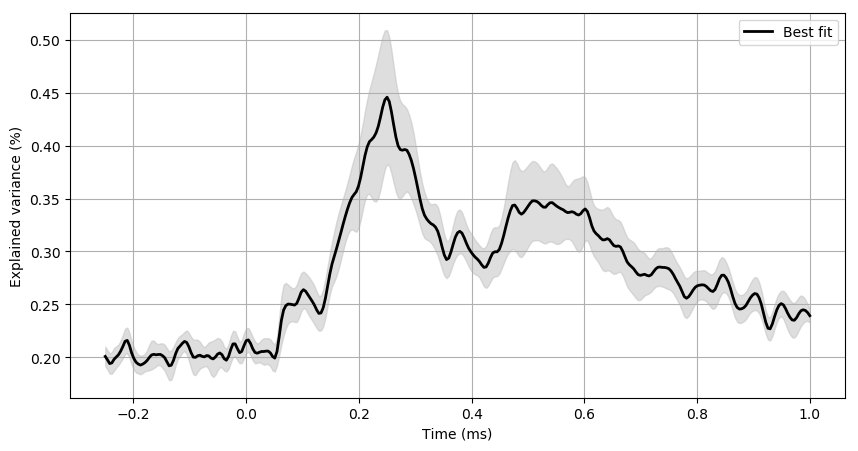

In [99]:
plotBestR2(t, maxR2_, maxR2List);